### References

https://medium.com/bioquest/pyseal-homomorphic-encryption-in-a-user-friendly-python-package-51dd6cb0411c

# Imports

In [1]:
# General python libraries
import numpy as np
import matplotlib as plt

# PySEAL imports - taken from SEALPythonExamples/examples.py
import time
import random
import threading
import seal
from seal import ChooserEvaluator,     \
                 Ciphertext,           \
                 Decryptor,            \
                 Encryptor,            \
                 EncryptionParameters, \
                 Evaluator,            \
                 IntegerEncoder,       \
                 FractionalEncoder,    \
                 KeyGenerator,         \
                 MemoryPoolHandle,     \
                 Plaintext,            \
                 SEALContext,          \
                 EvaluationKeys,       \
                 GaloisKeys,           \
                 PolyCRTBuilder,       \
                 ChooserEncoder,       \
                 ChooserEvaluator,     \
                 ChooserPoly


General PySEAL parameters - see http://130.56.248.129:8889/edit/SEALPythonExamples/examples.py . A high modulus slows computation down, but seems necessary to generate correct results.

In [2]:
# General params
parms = EncryptionParameters()
parms.set_poly_modulus("1x^8192 + 1")
parms.set_coeff_modulus(seal.coeff_modulus_128(8192))
parms.set_plain_modulus(786433)
context = SEALContext(parms)

Set up the secret and public keys.

In [3]:
keygen = KeyGenerator(context)
public_key = keygen.public_key()
secret_key = keygen.secret_key()

Create encryption, evaluator, decryption and encoder objects.

In [4]:
encryptor = Encryptor(context, public_key)
evaluator = Evaluator(context)
decryptor = Decryptor(context, secret_key)
encoder = FractionalEncoder(context.plain_modulus(), context.poly_modulus(), 64, 32, 3)

The 'Cloud' class represents an abstraction of a cloud service provider. It does look like the public key is needed for computation, but the secret key is never provided. The PySEAL Context object also needs to be supplied to the constructor - this ensures the same cryptographic parameters are used in computations as the client is using. 

Basic operations include 'zero' (creates an encryption of 0, necessary for calculation); 'mean', 'variance', and an arbitrary function, 'at_risk'.

Note standard deviation cannot be implemented, since PySEAL (and SEAL) does not support square root, division (of encrypted variables), or comparison operators. 

'at_risk' determines whether a given value is in the upper 5 percentile of the data supplied to the Cloud object. It assumes the data is normally distributed, and that the upper 5 percentile is therefore calculated by determining whether the value is > two standard deviations above the mean ($ x > \mu + 2\sigma $). Since it is not possible (?) to calculate standard deviation directly, the following equivalent is used: $ (x - \mu)^2 - (2\sigma)^2 > 0 $. Since variance can be calculated, and is equal to $\sigma^2$, we can obtain the same result.



In [67]:
class Cloud:
    def __init__(self, context, public_key):
        self.context = context
        self.encryptor = Encryptor(self.context, public_key)
        self.evaluator = Evaluator(self.context)
        self.encoder = FractionalEncoder(self.context.plain_modulus(), self.context.poly_modulus(), 64, 32, 3)
        
    def submit_to_the_cloud(self, encrypted_data):
        self.encrypted_data = encrypted_data
    
    def submit_to_the_cloud_and_encrypt(self, plain_data):
        encrypted_data = []
        for i in range(len(plain_data)):
            encrypted_data.append(Ciphertext(self.context.parms()))
            self.encryptor.encrypt(self.encoder.encode(plain_data[i]), encrypted_data[i])
        self.submit_to_the_cloud(encrypted_data)
    
    def zero(self):
        value = 0;
        plain = self.encoder.encode(value)
        encrypted_zero = Ciphertext(self.context.parms())
        self.encryptor.encrypt(plain, encrypted_zero)
        return encrypted_zero
        
    def mean(self):
        encrypted_result = self.zero()
        data = np.ndarray.flatten(np.array(self.encrypted_data))
        self.evaluator.add_many(data, encrypted_result)
        divisor = self.encoder.encode(1 / len(data))
        self.evaluator.multiply_plain(encrypted_result, divisor)
        return encrypted_result
    
    def variance(self):
        mu = self.mean()
        data = np.ndarray.flatten(np.array(self.encrypted_data))
        encrypted_result = self.zero()
        variances = []
        for i in range(len(data)):
            d = data[i]
            variances.append(self.zero())
            res = variances[i]
            self.evaluator.add(res, d)
            self.evaluator.negate(res)
            self.evaluator.add(res, mu)
            self.evaluator.square(res)
        encrypted_result = Ciphertext()
        evaluator.add_many(variances, encrypted_result)
        divisor = self.encoder.encode(1 / len(data))
        evaluator.multiply_plain(encrypted_result, divisor)
        return encrypted_result
            
    # "At risk" means mean + 2 x sigma, i.e. ~top 5 percentile
    # Convoluted calculation, due to no square root, division or comparison with zero
    # Once decrypted, > 0 means at risk
    def at_risk(self, encrypted_value):
        mu = self.mean()
        evaluator.negate(mu)
        sigma = self.variance()
        evaluator.multiply_plain(sigma, self.encoder.encode(4)) 
        evaluator.negate(sigma)

        evaluator.add(encrypted_value, mu)
        evaluator.square(encrypted_value)
        evaluator.add(encrypted_value, sigma)
        return encrypted_value


Blood pressure values. Taken from https://thl.fi/publications/monica/bp/table8.htm.

The values are normally distributed around $\mu = 131$ and $\sigma = 18$. $N$ is set to 25 - at least with the PySEAL parameters set above, anything more becomes inaccurate and slow.

In [114]:
mu = 131
sigma = 18
# Create a sample with 
N=25
blood_pressure = sigma * np.random.randn(N) + mu



Encrypt blood pressure values

In [115]:
encrypted_rationals = []
for i in range(len(blood_pressure)):
    encrypted_rationals.append(Ciphertext(parms))
    encryptor.encrypt(encoder.encode(blood_pressure[i]), encrypted_rationals[i])

Check non-encrypted values.

In [116]:
print("Unencrypted mean: " + (str)(np.mean(blood_pressure))[:8])
print("Unencrypted variance: " + (str)(np.var(blood_pressure))[:8])
print("Unencrypted std. dev.: " + (str)(np.std(blood_pressure))[:8])


Unencrypted mean: 128.3476
Unencrypted variance: 161.2943
Unencrypted std. dev.: 12.70017


Simple test of our "Cloud". Tests that a zero value is created.

In [117]:
cloud = Cloud(context, public_key)
z = cloud.zero()

In [118]:
plain_result = Plaintext()
decryptor.decrypt(z, plain_result)
result = encoder.decode(plain_result)
print("Zero: " + (str)(result)[:8])


Zero: 0.0


Create a "Cloud", submit some data, and obtain the mean and variance.

In [119]:
cloud = Cloud(context, public_key)
cloud.submit_to_the_cloud(encrypted_rationals)
mu = cloud.mean()
variance = cloud.variance()



Output cloud-generated values.

In [120]:

plain_result = Plaintext()
decryptor.decrypt(mu, plain_result)
result = encoder.decode(plain_result)
print("Blood pressure average: " + (str)(result)[:8])
plain_result = Plaintext()
decryptor.decrypt(variance, plain_result)
result = encoder.decode(plain_result)
print("Blood pressure variance: " + (str)(result)[:8])
print("Blood pressure std. dev.: " + (str)(np.sqrt(result))[:8])


Blood pressure average: 128.3476
Blood pressure variance: 161.2885
Blood pressure std. dev.: 12.69994


Create a test patient value to compare.

In [17]:
patient_X_bp = 160
encrypted_patient_value = Ciphertext(parms)
encryptor.encrypt(encoder.encode(patient_X_bp), encrypted_patient_value)

In [18]:
sq_mu = np.mean(blood_pressure)
print(sq_mu)
sq_mu = np.var(blood_pressure)
print(sq_mu * 4)
print(np.square(patient_X_bp - np.mean(blood_pressure)))

132.92851180752135
1069.7972026453433
732.8654729555112


Check whether the patient is "at risk".

In [23]:
ar = cloud.at_risk(encrypted_patient_value)
plain_result = Plaintext()
decryptor.decrypt(ar, plain_result)
result = encoder.decode(plain_result)
print("Blood pressure at risk: " + (str)(result > 0))

Blood pressure at risk: False


In [21]:
cloud = Cloud(context, public_key)
cloud.submit_to_the_cloud_and_encrypt(blood_pressure)
encrypted_result = cloud.mean()

In [22]:
plain_result = Plaintext()
decryptor.decrypt(encrypted_result, plain_result)
result = encoder.decode(plain_result)
print("Blood pressure average: " + (str)(result)[:8])

Blood pressure average: 132.9285


In [121]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]



In [147]:
[*blood_pressure, patient_X_bp]

[113.18595537979746,
 133.46325114715916,
 125.62811333313327,
 123.23578382383982,
 124.37332277018886,
 136.3391938040851,
 126.27193584861733,
 143.39651340965577,
 131.82466692301261,
 114.7648227089153,
 112.93807378891961,
 137.42499751431495,
 131.94021117650556,
 106.4315915122763,
 114.81226026379021,
 104.85529251378823,
 121.08857814425843,
 122.06616858240167,
 130.31843538351615,
 149.0789346839901,
 126.6621528463028,
 150.83878699793217,
 146.3289003553568,
 137.24379316917882,
 144.17848934549932,
 160]

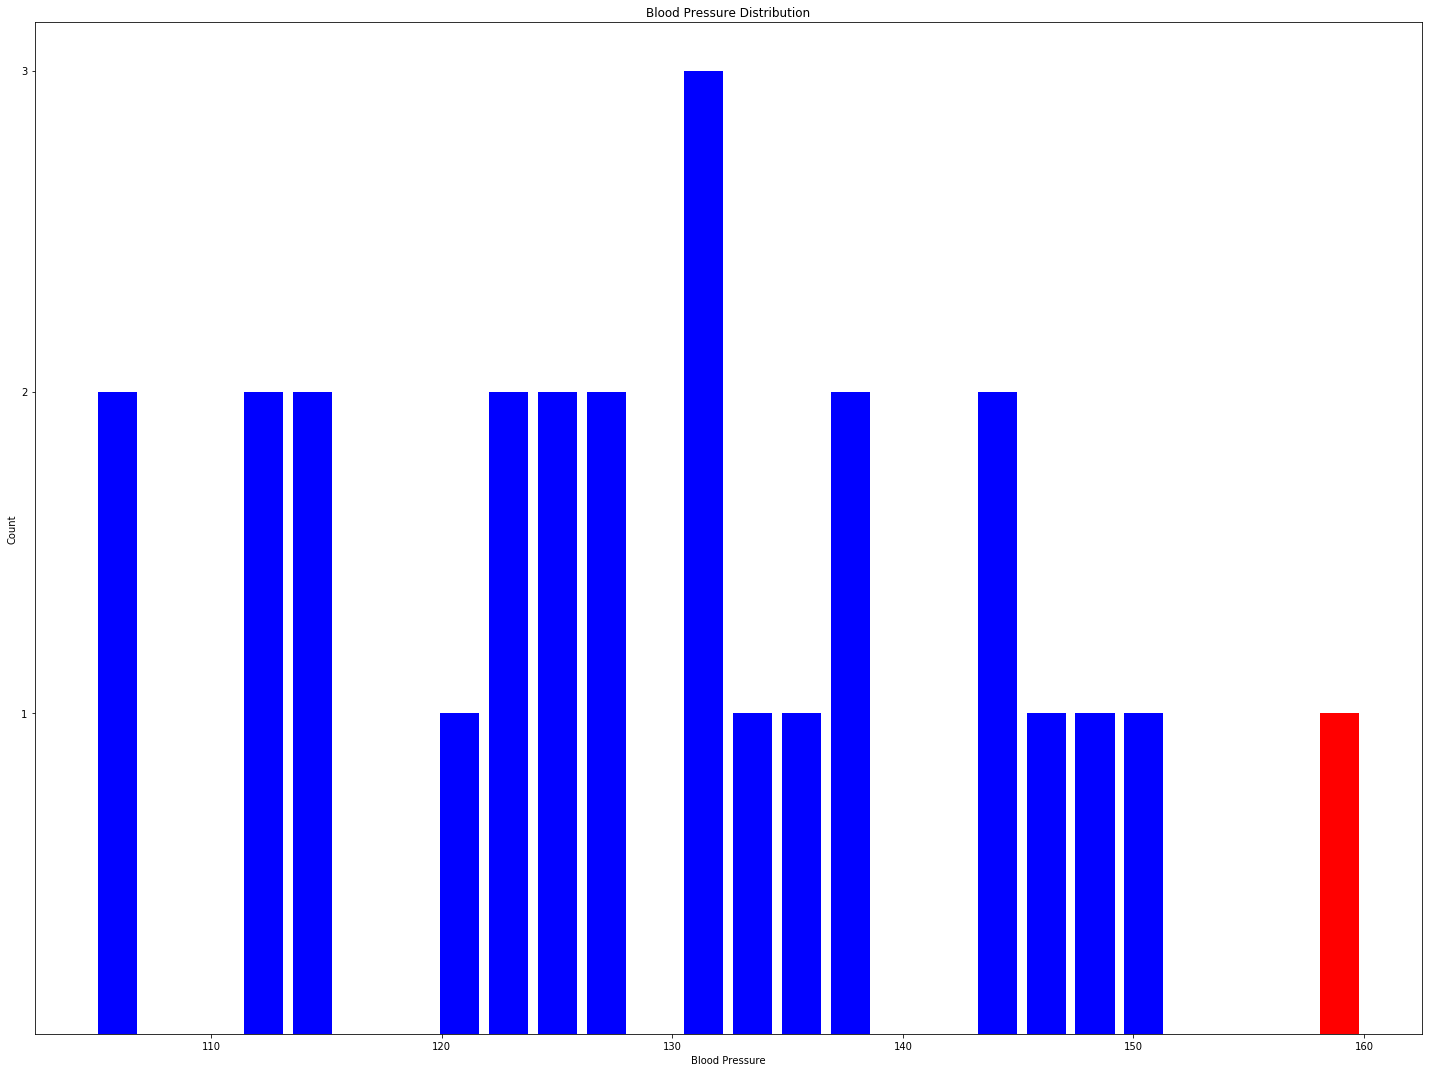

In [155]:
fig, ax = plt.subplots()
plottable = [*blood_pressure, patient_X_bp]
num_bins = len(plottable)
index = np.arange(n_groups)
# the histogram of the data
n, bins, patches = ax.hist(plottable, num_bins, density=False, rwidth = 0.8)
[patches[i].set_facecolor('b') for i in range(num_bins-1)]
patches[num_bins-1].set_facecolor('r')

ax.set_xlabel('Blood Pressure')
ax.set_ylabel('Count')
ax.set_yticks([1, 2, 3])
ax.set_title('Blood Pressure Distribution')

fig.tight_layout()
plt.show()